In [1]:
!pip install openpyxl #for loading xlsx files using pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.2/242.2 KB 1.4 MB/s eta 0:00:00


## Importing Necessary Libraries

In [2]:
import os
import copy
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image    
import torch
from torch import optim
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import torchvision.transforms as transforms
from sklearn import metrics
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

src = ".."
device = "cuda:0"
frame_count = 25

#### Loading generated dataframe for Train and Valid set

In [3]:
Train = pd.read_excel("{}/Train.xlsx".format(src))
Valid = pd.read_excel("{}/Valid.xlsx".format(src))

In [4]:
Train.head()

,ID,Path,Modality,Vocal Channel,Emotion,Emotional intensity,Statement,Repetition,Actor
0,01-01-01-01-01-01-01,audio-video/Actor_01/01-01-01-01-01-01-01.mp4,full-AV,speech,neutral,normal,Kids are talking by the door,1st repetition,1
1,01-01-01-01-01-02-01,audio-video/Actor_01/01-01-01-01-01-02-01.mp4,full-AV,speech,neutral,normal,Kids are talking by the door,2nd repetition,1
2,01-01-01-01-02-01-01,audio-video/Actor_01/01-01-01-01-02-01-01.mp4,full-AV,speech,neutral,normal,Dogs are sitting by the door,1st repetition,1
3,01-01-01-01-02-02-01,audio-video/Actor_01/01-01-01-01-02-02-01.mp4,full-AV,speech,neutral,normal,Dogs are sitting by the door,2nd repetition,1
4,01-01-02-01-01-01-01,audio-video/Actor_01/01-01-02-01-01-01-01.mp4,full-AV,speech,calm,normal,Kids are talking by the door,1st repetition,1


In [5]:
emotion = {
    "neutral": 0, 
    "calm": 1, 
    "happy": 2, 
    "sad": 3, 
    "angry": 4, 
    "fearful": 5, 
    "disgust": 6, 
    "surprised": 7
}

reverse_emotion = {y: x for x, y in emotion.items()}

## Initializing custom Dataset class

#### Stacking frames per video and putting channel first in tensor instead of number of frames for Resnet18Conv3d

In [6]:
class myDataset(Dataset):
    def __init__(self, df, path, frame_count, emotion, transform=None):
        self.df = df
        self.path = path
        self.frame_count = frame_count
        self.emotion = emotion
        self.transform = transform
    
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        directory = "{}/{}".format(self.path, self.df["ID"].iloc[idx]) #name of a video
        files = ["{}/{}".format(directory, x) for x in os.listdir(directory)] #list of all stored frames in a given video
        frames = []
        for file in files[:self.frame_count]:
            image = Image.open(file)
            image = self.transform(image)
            frames.append(image) #appending frame to list
        imgs_tensor = torch.stack(frames)
        imgs_tensor = imgs_tensor.transpose(1,0) #(25, 3, 112, 112) -> (3, 25, 112, 112)
        label = self.emotion[self.df["Emotion"].iloc[idx]] #converting label to index
        
        return imgs_tensor, label

#### Instantiating dataset and dataloader, and using a simple transform for marking baseline performance

In [7]:
transform = transforms.Compose([
            transforms.Resize((112,112)),
            transforms.ToTensor(),
            transforms.Normalize(
                [0.43216, 0.394666, 0.37645], 
                [0.22803, 0.22145, 0.216989]
            )
]) 

src = "../frames"
trainset = myDataset(Train, src, frame_count, emotion, transform)
validset = myDataset(Valid, src, frame_count, emotion, transform)

trainloader = DataLoader(trainset, batch_size=4, shuffle=True)
validloader = DataLoader(validset, batch_size=2, shuffle=False)

In [8]:
image, label = next(iter(trainloader)) #verifying shape of image and label from dataloader
print(image.shape, label.shape)

torch.Size([4, 3, 25, 112, 112]) torch.Size([4])


## Initializing custom Model class

#### We used a ResNet 3D model. It is a model for video that employs 3D convolutions. It factorizes 3D convolution into two separate and successive operations, a 2D spatial convolution and a 1D temporal convolution.

In [9]:
class Resnet18Conv3d(nn.Module):
    def __init__(self, config):
        super(Resnet18Conv3d, self).__init__()
        num_classes = config["num_classes"]
        pretrained = config["pretrained"]
        
        self.model = models.video.r3d_18(pretrained=pretrained)
        num_features = self.model.fc.in_features
        self.model.fc = nn.Linear(num_features, num_classes) #replacing final layer with linear layer for custom num_classes
    
    def forward(self, x):
        out = self.model(x) 
        return out 

## Defining configuration for training

In [10]:
config = {  
    "epochs": 15,
    "path2weights": "best.pt",
    "num_classes": len(emotion.keys()),
    "pretrained" : True,
    "trainloader": trainloader,
    "validloader": validloader,
    "sanity_check": False,
}

## Defining functions for training model

In [11]:
def trainModel(model, criterion, optimizer, scheduler, config):
    epochs=config["epochs"]
    trainloader=config["trainloader"]
    validloader=config["validloader"]
    sanity_check=config["sanity_check"]
    path2weights=config["path2weights"]
    
    #for plotting
    loss_history={
        "train": [],
        "val": [],
    }
    #for plotting
    metric_history={
        "train": [],
        "val": [],
    }
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss=float('inf')
    
    for epoch in range(epochs):
        current_lr=get_lr(optimizer)
        print('Epoch {}/{}, current lr = {}'.format(epoch, epochs-1, current_lr))
        model.train() #for training
        train_loss, train_metric = oneEpoch(model, criterion, trainloader, sanity_check, optimizer) #one training epoch
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        model.eval() #for validation
        with torch.no_grad():
            val_loss, val_metric = oneEpoch(model, criterion, validloader, sanity_check) #one validation epoch
        #saving weights from best model
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), path2weights)
            print("Copied best model weights!")
        
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)
        
        #updating learning rate scheduler
        scheduler.step(val_loss)
        if current_lr != get_lr(optimizer):
            print("Loading best model weights!")
            model.load_state_dict(best_model_wts)
        
        print("Train Loss: %.6f, Val Loss: %.6f, Val Acc: %.2f" %(train_loss,val_loss,100*val_metric))
        print("-"*10) 
    #reloading best weights
    model.load_state_dict(best_model_wts)
        
    return model, loss_history, metric_history


#get learning rate 
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

#get metrics for a batch
def metrics_batch(output, target): 
    pred = output.argmax(dim=1, keepdim=True) #picking highest probability index
    corrects = pred.eq(target.view_as(pred)).sum().item() 
    return corrects

#performing backward propagation
def loss_batch(criterion, output, target, optimizer=None):
    loss = criterion(output, target)
    with torch.no_grad():
        metric_b = metrics_batch(output,target)
    if optimizer is not None:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return loss.item(), metric_b
    
#iterating through all batches in a given epoch
def oneEpoch(model, criterion, dataloader, sanity_check=False, optimizer=None):
    running_loss, running_metric = 0.0, 0.0
    len_data = len(dataloader.dataset)
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device) #shifting data to gpu from cpu
        output = model(inputs)
        loss_b, metric_b = loss_batch(criterion, output, labels, optimizer)
        running_loss += loss_b
        
        if metric_b is not None:
            running_metric += metric_b
        if sanity_check is True:
            break
    loss=running_loss/float(len_data)
    metric=running_metric/float(len_data)
    return loss, metric

## Starting training

In [12]:
model = Resnet18Conv3d(config) #instantiating model
model.to(device) #shifting model to gpu from cpu
criterion = nn.CrossEntropyLoss(reduction="sum") #loss function
optimizer = optim.Adam(model.parameters(), lr=3e-4) #optimizer
scheduler = ReduceLROnPlateau(optimizer, mode='min',factor=0.5, patience=5,verbose=1) #learning rate scheduler
model, loss_history, metric_history = trainModel(model, criterion, optimizer, scheduler, config)

Downloading: "https://download.pytorch.org/models/r3d_18-b3b3357e.pth" to /root/.cache/torch/hub/checkpoints/r3d_18-b3b3357e.pth


  0%|          | 0.00/127M [00:00<?, ?B/s]

Epoch 0/14, current lr = 0.0003
Copied best model weights!
Train Loss: 1.173999, Val Loss: 2.086098, Val Acc: 49.38
----------
Epoch 1/14, current lr = 0.0003
Copied best model weights!
Train Loss: 0.657125, Val Loss: 1.508547, Val Acc: 52.29
----------
Epoch 2/14, current lr = 0.0003
Train Loss: 0.365507, Val Loss: 1.623317, Val Acc: 52.08
----------
Epoch 3/14, current lr = 0.0003
Train Loss: 0.236231, Val Loss: 1.975328, Val Acc: 46.25
----------
Epoch 4/14, current lr = 0.0003
Train Loss: 0.169574, Val Loss: 1.586291, Val Acc: 55.00
----------
Epoch 5/14, current lr = 0.0003
Train Loss: 0.185958, Val Loss: 1.985982, Val Acc: 53.33
----------
Epoch 6/14, current lr = 0.0003
Copied best model weights!
Train Loss: 0.124946, Val Loss: 1.269933, Val Acc: 62.71
----------
Epoch 7/14, current lr = 0.0003
Train Loss: 0.098500, Val Loss: 1.593108, Val Acc: 56.25
----------
Epoch 8/14, current lr = 0.0003
Train Loss: 0.150076, Val Loss: 1.747964, Val Acc: 49.58
----------
Epoch 9/14, current

## Plotting Graphs

In [13]:
def plot_loss(loss_hist, metric_hist):

    epochs= len(loss_hist["train"])

    plt.title("Train-Val Loss")
    plt.plot(range(1, epochs+1),loss_hist["train"],label="train")
    plt.plot(range(1, epochs+1),loss_hist["val"],label="val")
    plt.ylabel("Loss")
    plt.xlabel("Training Epochs")
    plt.legend()
    plt.show()

    plt.title("Train-Val Accuracy")
    plt.plot(range(1, epochs+1), metric_hist["train"],label="train")
    plt.plot(range(1, epochs+1), metric_hist["val"],label="val")
    plt.ylabel("Accuracy")
    plt.xlabel("Training Epochs")
    plt.legend()
    plt.show()

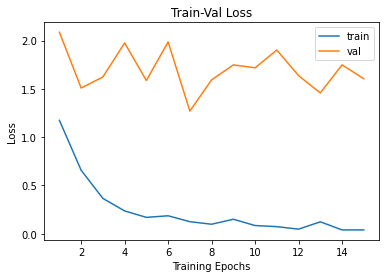

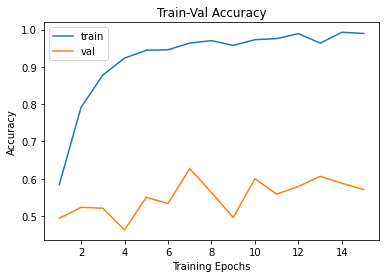

In [14]:
plot_loss(loss_history, metric_history)

#### Confusion Matrix and Classification Report (Precision, Recall, F1-Score) for Validation Set

In [15]:
testset = myDataset(Valid, src, frame_count, emotion, transform)
testloader = DataLoader(testset, batch_size=2, shuffle=False)

lbl_list, out_list = [], []
for inputs, labels in tqdm(testloader):
    inputs, labels = inputs.to(device), labels.to(device) #shifting data to gpu from cpu
    output = model(inputs).argmax(dim=1, keepdim=True) #picking highest probability index
    lbl_list.extend(labels)
    out_list.extend(output)

pred = [reverse_emotion[x.item()] for x in out_list]
true = [reverse_emotion[x.item()] for x in lbl_list]

print("CONFUSION MATRIX\n")
print(metrics.confusion_matrix(true, pred))
print("\n\nCLASSIFICATION REPORT\n")
print(metrics.classification_report(true, pred, digits=3));

100%|██████████| 240/240 [00:58<00:00,  4.11it/s]

CONFUSION MATRIX

[[46  0  2  0  0  0  8  8]
 [ 0 42  0  0  3  8  0 11]
 [19  8 26  0  0  0 10  1]
 [ 4  0  0 44  0  1  0 15]
 [ 0  6  0  0 46  2  0 10]
 [ 2  0  0  0  0 26  0  4]
 [ 2  4  0  0  0 10 39  9]
 [ 8  1  0  9  4  3  7 32]]


CLASSIFICATION REPORT

              precision    recall  f1-score   support

       angry      0.568     0.719     0.634        64
        calm      0.689     0.656     0.672        64
     disgust      0.929     0.406     0.565        64
     fearful      0.830     0.688     0.752        64
       happy      0.868     0.719     0.786        64
     neutral      0.520     0.812     0.634        32
         sad      0.609     0.609     0.609        64
   surprised      0.356     0.500     0.416        64

    accuracy                          0.627       480
   macro avg      0.671     0.639     0.634       480
weighted avg      0.681     0.627     0.634       480



#### Confusion Matrix and Classification Report (Precision, Recall, F1-Score) for Validation Set with respect to each sentence

In [16]:
statements = ["Kids are talking by the door", "Dogs are sitting by the door"]

for statement in statements: 
    Test = Valid[Valid["Statement"] == statement]
    testset = myDataset(Test, src, frame_count, emotion, transform)
    testloader = DataLoader(testset, batch_size=2, shuffle=False)

    lbl_list, out_list = [], []
    for inputs, labels in tqdm(testloader):
        inputs, labels = inputs.to(device), labels.to(device) #shifting data to gpu from cpu
        output = model(inputs).argmax(dim=1, keepdim=True) #picking highest probability index
        lbl_list.extend(labels)
        out_list.extend(output)

    pred = [reverse_emotion[x.item()] for x in out_list]
    true = [reverse_emotion[x.item()] for x in lbl_list]

    print("CONFUSION MATRIX for '{}'\n".format(statement))
    print(metrics.confusion_matrix(true, pred))
    print("\n\nCLASSIFICATION REPORT for '{}'\n".format(statement))
    print(metrics.classification_report(true, pred, digits=3));
    print("\n\n")

100%|██████████| 120/120 [00:28<00:00,  4.16it/s]


CONFUSION MATRIX for 'Kids are talking by the door'

[[22  0  2  0  0  0  4  4]
 [ 0 21  0  0  3  2  0  6]
 [ 9  4 12  0  0  0  6  1]
 [ 2  0  0 22  0  0  0  8]
 [ 0  0  0  0 24  2  0  6]
 [ 0  0  0  0  0 12  0  4]
 [ 2  2  0  0  0  0 21  7]
 [ 0  1  0  6  2  1  7 15]]


CLASSIFICATION REPORT for 'Kids are talking by the door'

              precision    recall  f1-score   support

       angry      0.629     0.688     0.657        32
        calm      0.750     0.656     0.700        32
     disgust      0.857     0.375     0.522        32
     fearful      0.786     0.688     0.733        32
       happy      0.828     0.750     0.787        32
     neutral      0.706     0.750     0.727        16
         sad      0.553     0.656     0.600        32
   surprised      0.294     0.469     0.361        32

    accuracy                          0.621       240
   macro avg      0.675     0.629     0.636       240
weighted avg      0.673     0.621     0.630       240






100%|██████████| 120/120 [00:29<00:00,  4.10it/s]

CONFUSION MATRIX for 'Dogs are sitting by the door'

[[24  0  0  0  0  0  4  4]
 [ 0 21  0  0  0  6  0  5]
 [10  4 14  0  0  0  4  0]
 [ 2  0  0 22  0  1  0  7]
 [ 0  6  0  0 22  0  0  4]
 [ 2  0  0  0  0 14  0  0]
 [ 0  2  0  0  0 10 18  2]
 [ 8  0  0  3  2  2  0 17]]


CLASSIFICATION REPORT for 'Dogs are sitting by the door'

              precision    recall  f1-score   support

       angry      0.522     0.750     0.615        32
        calm      0.636     0.656     0.646        32
     disgust      1.000     0.438     0.609        32
     fearful      0.880     0.688     0.772        32
       happy      0.917     0.688     0.786        32
     neutral      0.424     0.875     0.571        16
         sad      0.692     0.562     0.621        32
   surprised      0.436     0.531     0.479        32

    accuracy                          0.633       240
   macro avg      0.688     0.648     0.637       240
weighted avg      0.706     0.633     0.642       240




